In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import time
from random import shuffle
import glob

import torch
import glob
import cv2

from torch.utils.data import DataLoader

from models import Yolov4
from tool.utils import nms_cpu, plot_boxes_cv2
from tool.torch_utils import do_detect

from train_acne import evaluate
from dataset_acne04 import ACNE04
from cfg_acne04 import Cfg

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['STFangsong']
mpl.rcParams['figure.figsize'] = (20, 3)

%matplotlib inline

In [3]:
model_path = "./saved_models/Yolov4_epoch385.pth"

In [4]:
os.path.isfile(model_path)

True

In [5]:
filtered_image_path = "/export/servers/data/acne_article_data/filtered_images/"
all_fi = [os.path.join(filtered_image_path, item) for item in os.listdir(filtered_image_path)]

In [6]:
glob.glob(os.path.join(filtered_image_path, "*.jpg"))

['/export/servers/data/acne_article_data/filtered_images/levle0_1.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_100.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_101.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_102.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_103.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_104.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_105.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_106.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_107.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_108.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_109.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_110.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_111.jpg',
 '/export/servers/data/acne_article_data

In [7]:
model = Yolov4(None,1,True)

In [8]:
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
model.eval()

Yolov4(
  (down1): DownSample1(
    (conv1): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv2): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv3): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv4): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNo

In [44]:

"""
"""
import os
import time
import glob
from random import shuffle
from numbers import Real
import matplotlib.pyplot as plt

import torch
import cv2
from easydict import EasyDict as ED

from cfg_acne04 import Cfg
from tool.utils import nms_cpu
from tool.torch_utils import do_detect


_CV2_GREEN = (0, 255, 0)


def detect_and_draw(model, image_path, conf_thresh=0.5, show=False, **kwargs):
    """
    """
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image, (Cfg.width, Cfg.height))

    detected_boxes = do_detect(model, resized, conf_thresh, 0.5, False)[0]
    detected_acne_num = len(detected_boxes)
    img_with_boxes, detected_boxes, detected_scores = plot_boxes_cv2(image, detected_boxes)
    detected_severity = to_severity(detected_acne_num)

    if show:
        title = kwargs.get("title", None)
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=kwargs.get("figsize", (30, 18)))
        ax1.imshow(img_with_boxes)
        ax2.imshow(image)
        if title:
            ax1.set_title(title+f'\ndetected number {detected_acne_num}', y=-0.1, fontsize=20)
            ax1.axis("off")
            ax2.set_title('original image', y=-0.1, fontsize=20)
            ax2.axis("off")
        if kwargs.get("savefig", False):
            fmt = kwargs.get("fmt", "png")
            plt.savefig(f"./fig/{title or str(int(time.time()))}.{fmt}", bbox_inches='tight', transparent=True)
        plt.show()

    return detected_acne_num, detected_boxes, detected_scores, detected_severity


def plot_boxes_cv2(img, boxes, color=_CV2_GREEN):
    """
    """
    img_with_boxes = np.copy(img)
    boxes_on_img = []
    box_scores = []
    
    line_size = max(1, int(max(img_with_boxes.shape[:2]) / 500))
    font_size = line_size + 1

    width = img_with_boxes.shape[1]
    height = img_with_boxes.shape[0]
    for i in range(len(boxes)):
        box = boxes[i]
        x1 = int((box[0] - box[2] / 2.0) * width)
        y1 = int((box[1] - box[3] / 2.0) * height)
        x2 = int((box[0] + box[2] / 2.0) * width)
        y2 = int((box[1] + box[3] / 2.0) * height)
        boxes_on_img.append([x1,y1,x2,y2])
        box_scores.append(box[5])

        if color:
            rgb = color
        else:
            rgb = _CV2_GREEN
        
        # img_with_boxes = cv2.putText(img_with_boxes, 'acne', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1.2, rgb, font_size)
        img_with_boxes = cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), rgb, line_size)

    return img_with_boxes, boxes_on_img, box_scores


def to_severity(lesions_num:Real) -> int:
    """
    The Hayashi criterion
    The appropriate divisions of inflammatory eruptions of half of the face to decide classifications were:     0-5, "mild";
        6-20, "moderate";
        21-50, "severe";
        >=50, "very severe"
    Reference:
    [1] Hayashi N, Akamatsu H, Kawashima M, et al. Establishment of grading criteria for acne severity[J]. The Journal of dermatology, 2008, 35(5): 255-260.
    [2] https://www.ncbi.nlm.nih.gov/pubmed/18477223
    """
    if lesions_num <= 5:
        return 0
    elif lesions_num <= 20:
        return 1
    elif lesions_num <= 50:
        return 2
    else:
        return 3


def inference(model, image_path, conf_thresh=[0.5], use_cuda=False):
    """
    inference on single image
    """
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image, (Cfg.width, Cfg.height))
    resized = torch.from_numpy(resized.transpose(2, 0, 1)).float().div(255.0).unsqueeze(0)

    if use_cuda:
        resized = resized.cuda()
    resized = torch.autograd.Variable(resized)

    raw_output = model(resized)
    raw_output = raw_output.cpu().detach().numpy()

    box_array = raw_output[:, :, :4]
    confs = raw_output[:, :, 4:]

    # [batch, num, num_classes] --> [batch, num]
    max_conf = np.max(confs, axis=2)
    max_id = np.argmax(confs, axis=2)

    detected_boxes = {}
    for k in conf_thresh:
        detected_boxes[k] = []
        argwhere = max_conf[0] > k
        l_box_array = box_array[0, argwhere, :]
        l_max_conf = max_conf[0, argwhere]
        l_max_id = max_id[0, argwhere]

        keep = nms_cpu(l_box_array, l_max_conf, 0.5)
        
        if (keep.size > 0):
            l_box_array = l_box_array[keep, :]
            l_max_conf = l_max_conf[keep]
            l_max_id = l_max_id[keep]

            for j in range(l_box_array.shape[0]):
                detected_boxes[k].append([l_box_array[j, 0], l_box_array[j, 1], l_box_array[j, 2], l_box_array[j, 3], l_max_conf[j], l_max_conf[j], l_max_id[j]])

    detected_acne_num = {k:len(v) for k,v in detected_boxes.items()}
    detected_severity = {k:to_severity(v) for k,v in detected_acne_num.items()}

    ret = {
        k: {"acne_num": detected_acne_num[k], "severity": detected_severity[k]} \
            for k in conf_thresh
    }

    return ret


In [11]:
all_fi

['/export/servers/data/acne_article_data/filtered_images/levle0_1.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_100.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_101.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_102.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_103.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_104.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_105.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_106.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_107.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_108.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_109.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_110.jpg',
 '/export/servers/data/acne_article_data/filtered_images/levle0_111.jpg',
 '/export/servers/data/acne_article_data

In [17]:
all_fi[1000]

'/export/servers/data/acne_article_data/filtered_images/levle1_619.jpg'

-----------------------------------
           Preprocess : 0.001040
      Model Inference : 4.908271
-----------------------------------
-----------------------------------
       max and argmax : 0.001164
                  nms : 0.001358
Post processing total : 0.002522
-----------------------------------


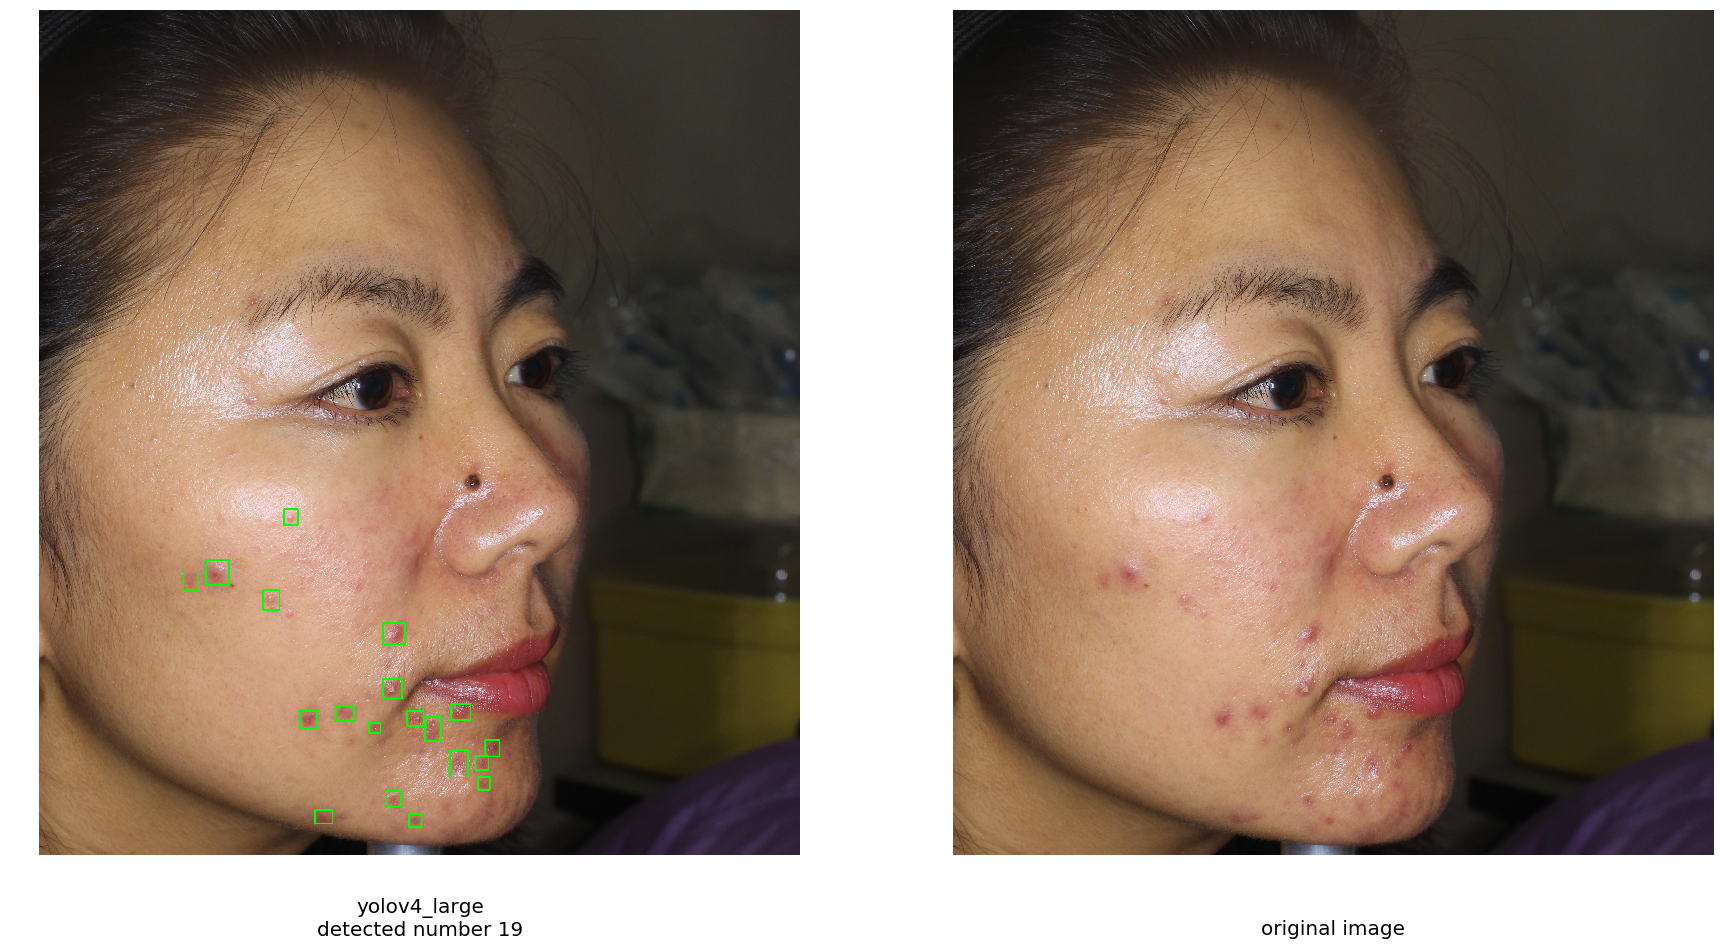

(19,
 [[1406, 2507, 1495, 2596],
  [1000, 2043, 1058, 2107],
  [1406, 2736, 1485, 2816],
  [681, 2249, 776, 2353],
  [1503, 2867, 1572, 2928],
  [1823, 2987, 1883, 3053],
  [1066, 2866, 1137, 2936],
  [1214, 2847, 1287, 2908],
  [1348, 2915, 1396, 2958],
  [1680, 3028, 1753, 3139],
  [1129, 3272, 1200, 3327],
  [1683, 2840, 1764, 2905],
  [1784, 3051, 1838, 3107],
  [1579, 2892, 1643, 2990],
  [591, 2297, 648, 2372],
  [1512, 3289, 1564, 3340],
  [916, 2374, 983, 2456],
  [1796, 3137, 1845, 3189],
  [1420, 3193, 1479, 3257]],
 [0.9999901,
  0.9998803,
  0.9998417,
  0.99983215,
  0.9998274,
  0.9998252,
  0.99981695,
  0.9998042,
  0.99977654,
  0.99972934,
  0.99967897,
  0.99942076,
  0.9993986,
  0.9991186,
  0.99825996,
  0.9978649,
  0.99627906,
  0.996132,
  0.99347335],
 1)

In [23]:
detect_and_draw(model, all_fi[1000], show=True, title='yolov4_large')

In [34]:
all_fi[1000]

'/export/servers/data/acne_article_data/filtered_images/levle1_619.jpg'

In [36]:
hehe = inference(model, all_fi[1000], [0.25,0.5,0.75])

resized.shape = torch.Size([1, 3, 608, 608])
raw_output.shape = (1, 22743, 5)


In [37]:
hehe

{0.25: {'acne_num': 19, 'severity': 1},
 0.5: {'acne_num': 19, 'severity': 1},
 0.75: {'acne_num': 19, 'severity': 1}}

In [46]:
def run_single(image_path):
    res = inference(model, image_path, [0.25, 0.5, 0.75, 0.9], False)
    print(f"{os.path.basename(image_path)} done")
    return res

In [47]:
run_single(all_fi[1000])

levle1_619.jpg done


{0.25: {'acne_num': 19, 'severity': 1},
 0.5: {'acne_num': 19, 'severity': 1},
 0.75: {'acne_num': 19, 'severity': 1},
 0.9: {'acne_num': 19, 'severity': 1}}

In [48]:
all_results = {}

for fp in all_fi:
    fn = os.path.splitext(os.path.basename(fp))[0]
    all_results[fn] = run_single(fp)

levle0_1.jpg done
levle0_100.jpg done
levle0_101.jpg done
levle0_102.jpg done
levle0_103.jpg done
levle0_104.jpg done
levle0_105.jpg done
levle0_106.jpg done
levle0_107.jpg done
levle0_108.jpg done
levle0_109.jpg done
levle0_110.jpg done
levle0_111.jpg done
levle0_112.jpg done
levle0_113.jpg done
levle0_114.jpg done
levle0_115.jpg done
levle0_116.jpg done
levle0_117.jpg done
levle0_118.jpg done
levle0_119.jpg done
levle0_120.jpg done
levle0_121.jpg done
levle0_122.jpg done
levle0_123.jpg done
levle0_124.jpg done
levle0_125.jpg done
levle0_126.jpg done
levle0_127.jpg done
levle0_128.jpg done
levle0_129.jpg done
levle0_130.jpg done
levle0_131.jpg done
levle0_132.jpg done
levle0_133.jpg done
levle0_134.jpg done
levle0_135.jpg done
levle0_136.jpg done
levle0_137.jpg done
levle0_138.jpg done
levle0_139.jpg done
levle0_141.jpg done
levle0_142.jpg done
levle0_143.jpg done
levle0_144.jpg done
levle0_145.jpg done
levle0_146.jpg done
levle0_147.jpg done
levle0_148.jpg done
levle0_149.jpg done
le

levle0_511.jpg done
levle0_512.jpg done
levle0_513.jpg done
levle0_514.jpg done
levle0_515.jpg done
levle0_516.jpg done
levle0_517.jpg done
levle0_518.jpg done
levle0_519.jpg done
levle0_52.jpg done
levle0_520.jpg done
levle0_521.jpg done
levle0_522.jpg done
levle0_523.jpg done
levle0_524.jpg done
levle0_525.jpg done
levle0_526.jpg done
levle0_527.jpg done
levle0_528.jpg done
levle0_529.jpg done
levle0_53.jpg done
levle0_530.jpg done
levle0_531.jpg done
levle0_54.jpg done
levle0_55.jpg done
levle0_56.jpg done
levle0_57.jpg done
levle0_58.jpg done
levle0_59.jpg done
levle0_60.jpg done
levle0_61.jpg done
levle0_62.jpg done
levle0_63.jpg done
levle0_64.jpg done
levle0_67.jpg done
levle0_68.jpg done
levle0_74.jpg done
levle0_75.jpg done
levle0_76.jpg done
levle0_77.jpg done
levle0_78.jpg done
levle0_79.jpg done
levle0_80.jpg done
levle0_81.jpg done
levle0_82.jpg done
levle0_83.jpg done
levle0_85.jpg done
levle0_86.jpg done
levle0_87.jpg done
levle0_88.jpg done
levle0_89.jpg done
levle0_90.

levle1_449.jpg done
levle1_45.jpg done
levle1_450.jpg done
levle1_454.jpg done
levle1_455.jpg done
levle1_456.jpg done
levle1_457.jpg done
levle1_458.jpg done
levle1_459.jpg done
levle1_46.jpg done
levle1_460.jpg done
levle1_461.jpg done
levle1_462.jpg done
levle1_463.jpg done
levle1_464.jpg done
levle1_465.jpg done
levle1_466.jpg done
levle1_467.jpg done
levle1_468.jpg done
levle1_469.jpg done
levle1_47.jpg done
levle1_470.jpg done
levle1_471.jpg done
levle1_472.jpg done
levle1_474.jpg done
levle1_475.jpg done
levle1_476.jpg done
levle1_477.jpg done
levle1_478.jpg done
levle1_479.jpg done
levle1_48.jpg done
levle1_480.jpg done
levle1_481.jpg done
levle1_482.jpg done
levle1_483.jpg done
levle1_484.jpg done
levle1_485.jpg done
levle1_486.jpg done
levle1_487.jpg done
levle1_488.jpg done
levle1_489.jpg done
levle1_49.jpg done
levle1_490.jpg done
levle1_491.jpg done
levle1_492.jpg done
levle1_493.jpg done
levle1_494.jpg done
levle1_495.jpg done
levle1_496.jpg done
levle1_497.jpg done
levle

In [49]:
all_results

{'levle0_1': {0.25: {'acne_num': 7, 'severity': 1},
  0.5: {'acne_num': 7, 'severity': 1},
  0.75: {'acne_num': 7, 'severity': 1},
  0.9: {'acne_num': 7, 'severity': 1}},
 'levle0_100': {0.25: {'acne_num': 2, 'severity': 0},
  0.5: {'acne_num': 1, 'severity': 0},
  0.75: {'acne_num': 1, 'severity': 0},
  0.9: {'acne_num': 1, 'severity': 0}},
 'levle0_101': {0.25: {'acne_num': 2, 'severity': 0},
  0.5: {'acne_num': 2, 'severity': 0},
  0.75: {'acne_num': 2, 'severity': 0},
  0.9: {'acne_num': 2, 'severity': 0}},
 'levle0_102': {0.25: {'acne_num': 6, 'severity': 1},
  0.5: {'acne_num': 6, 'severity': 1},
  0.75: {'acne_num': 6, 'severity': 1},
  0.9: {'acne_num': 6, 'severity': 1}},
 'levle0_103': {0.25: {'acne_num': 1, 'severity': 0},
  0.5: {'acne_num': 1, 'severity': 0},
  0.75: {'acne_num': 1, 'severity': 0},
  0.9: {'acne_num': 1, 'severity': 0}},
 'levle0_104': {0.25: {'acne_num': 0, 'severity': 0},
  0.5: {'acne_num': 0, 'severity': 0},
  0.75: {'acne_num': 0, 'severity': 0},
  0.

In [50]:
df_ann = pd.read_csv('/export/servers/data/acne/annotations_comprehensive.csv')

In [51]:
df_ann['img_ori_name'] = df_ann['img_filename'].apply(lambda fn:fn.replace("level", "levle"))
df_ann = df_ann[['img_ori_name','acne_lesion_num','severity_level']]
df_ann = df_ann[df_ann['img_ori_name'].isin([os.path.basename(item) for item in all_fi])].reset_index(drop=True)

In [52]:
df_ann

,img_ori_name,acne_lesion_num,severity_level
0,levle0_451.jpg,2,0
1,levle0_498.jpg,1,0
2,levle0_485.jpg,3,0
3,levle0_218.jpg,2,0
4,levle1_344.jpg,4,0
5,levle0_302.jpg,2,0
6,levle1_413.jpg,4,0
7,levle0_210.jpg,2,0
8,levle0_83.jpg,1,0
9,levle0_319.jpg,2,0


In [53]:
to_test_images = df_ann['img_ori_name'].values.tolist()
len(to_test_images)

1222

In [54]:
to_test_images[0]

'levle0_451.jpg'

In [57]:
res_90 = {fn:all_results[os.path.splitext(fn)[0]][0.9] for fn in to_test_images}
res_75 = {fn:all_results[os.path.splitext(fn)[0]][0.75] for fn in to_test_images}
res_50 = {fn:all_results[os.path.splitext(fn)[0]][0.5] for fn in to_test_images}
res_25 = {fn:all_results[os.path.splitext(fn)[0]][0.25] for fn in to_test_images}

In [60]:
df_ann['res25_num'] = df_ann['img_ori_name'].apply(lambda n:res_25[n]['acne_num'])
df_ann['res50_num'] = df_ann['img_ori_name'].apply(lambda n:res_50[n]['acne_num'])
df_ann['res75_num'] = df_ann['img_ori_name'].apply(lambda n:res_75[n]['acne_num'])
df_ann['res90_num'] = df_ann['img_ori_name'].apply(lambda n:res_90[n]['acne_num'])

df_ann['res25_level'] = df_ann['img_ori_name'].apply(lambda n:res_25[n]['severity'])
df_ann['res50_level'] = df_ann['img_ori_name'].apply(lambda n:res_50[n]['severity'])
df_ann['res75_level'] = df_ann['img_ori_name'].apply(lambda n:res_75[n]['severity'])
df_ann['res90_level'] = df_ann['img_ori_name'].apply(lambda n:res_90[n]['severity'])

In [62]:
df_ann["bias25"] = df_ann.apply(lambda row: row["res25_num"]-row["acne_lesion_num"], axis=1)
df_ann["bias50"] = df_ann.apply(lambda row: row["res50_num"]-row["acne_lesion_num"], axis=1)
df_ann["bias75"] = df_ann.apply(lambda row: row["res75_num"]-row["acne_lesion_num"], axis=1)
df_ann["bias90"] = df_ann.apply(lambda row: row["res90_num"]-row["acne_lesion_num"], axis=1)

In [63]:
df_ann

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,res25_level,res50_level,res75_level,res90_level,bias25,bias50,bias75,bias90
0,levle0_451.jpg,2,0,3,3,3,3,0,0,0,0,1,1,1,1
1,levle0_498.jpg,1,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
3,levle0_218.jpg,2,0,6,6,6,6,1,1,1,1,4,4,4,4
4,levle1_344.jpg,4,0,1,1,1,1,0,0,0,0,-3,-3,-3,-3
5,levle0_302.jpg,2,0,1,1,1,1,0,0,0,0,-1,-1,-1,-1
6,levle1_413.jpg,4,0,5,5,5,5,0,0,0,0,1,1,1,1
7,levle0_210.jpg,2,0,1,1,1,1,0,0,0,0,-1,-1,-1,-1
8,levle0_83.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
9,levle0_319.jpg,2,0,4,4,4,4,0,0,0,0,2,2,2,2


In [64]:
df_ann.describe()

,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,res25_level,res50_level,res75_level,res90_level,bias25,bias50,bias75,bias90
count,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000
mean,9.083470,0.762684,9.517185,9.067103,8.629296,8.226678,0.689853,0.659574,0.629296,0.599018,0.433715,-0.016367,-0.454173,-0.856792
std,10.545308,0.738093,9.773652,9.082139,8.434314,7.885764,0.697165,0.678669,0.657017,0.627984,6.647811,6.878236,7.174377,7.558450
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,-61.000000,-63.000000,-64.000000
25%,2.000000,0.000000,3.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-2.000000,-2.000000
50%,6.000000,1.000000,7.000000,6.000000,6.000000,6.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,1.000000,13.000000,12.000000,12.000000,12.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,2.000000,2.000000
max,65.000000,3.000000,76.000000,64.000000,54.000000,47.000000,3.000000,3.000000,3.000000,2.000000,28.000000,23.000000,21.000000,21.000000


In [65]:
mae_90 = np.mean(np.abs(df_ann['bias90'].values))
mae_25 = np.mean(np.abs(df_ann['bias25'].values))
mae_50 = np.mean(np.abs(df_ann['bias50'].values))
mae_75 = np.mean(np.abs(df_ann['bias75'].values))

In [66]:
mae_25, mae_50, mae_75, mae_90

(3.6104746317512273, 3.6530278232405893, 3.7749590834697218, 3.96481178396072)

In [69]:
rmse_90 = np.sqrt(np.mean((df_ann['bias90'].values)**2))
rmse_25 = np.sqrt(np.mean((df_ann['bias25'].values)**2))
rmse_50 = np.sqrt(np.mean((df_ann['bias50'].values)**2))
rmse_75 = np.sqrt(np.mean((df_ann['bias75'].values)**2))

In [70]:
rmse_25,rmse_50,rmse_75,rmse_90

(6.6592293484718095, 6.875440768492408, 7.1858084361137635, 7.603782760899938)

In [71]:
df_ann.head()

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,res25_level,res50_level,res75_level,res90_level,bias25,bias50,bias75,bias90
0,levle0_451.jpg,2,0,3,3,3,3,0,0,0,0,1,1,1,1
1,levle0_498.jpg,1,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
3,levle0_218.jpg,2,0,6,6,6,6,1,1,1,1,4,4,4,4
4,levle1_344.jpg,4,0,1,1,1,1,0,0,0,0,-3,-3,-3,-3


In [73]:
stats_by_lv = {}
for lv, df_lv in df_ann.groupby("severity_level"):
    lv_mae_90 = np.mean(np.abs(df_lv['bias90'].values))
    lv_mae_25 = np.mean(np.abs(df_lv['bias25'].values))
    lv_mae_50 = np.mean(np.abs(df_lv['bias50'].values))
    lv_mae_75 = np.mean(np.abs(df_lv['bias75'].values))
    lv_rmse_90 = np.sqrt(np.mean(np.abs(df_lv['bias90'].values)**2))
    lv_rmse_25 = np.sqrt(np.mean(np.abs(df_lv['bias25'].values)**2))
    lv_rmse_50 = np.sqrt(np.mean(np.abs(df_lv['bias50'].values)**2))
    lv_rmse_75 = np.sqrt(np.mean(np.abs(df_lv['bias75'].values)**2))
    lv_mean_90 = np.mean(df_lv['bias90'].values)
    lv_mean_25 = np.mean(df_lv['bias25'].values)
    lv_mean_50 = np.mean(df_lv['bias50'].values)
    lv_mean_75 = np.mean(df_lv['bias75'].values)
    lv_std_90 = np.std(df_lv['bias90'].values)
    lv_std_25 = np.std(df_lv['bias25'].values)
    lv_std_50 = np.std(df_lv['bias50'].values)
    lv_std_75 = np.std(df_lv['bias75'].values)
    stats_by_lv["level{}".format(lv)] = {"mae90":lv_mae_90, "mae25":lv_mae_25, "mae50":lv_mae_50, "mae75":lv_mae_75, "rmse90":lv_rmse_90, "rmse25":lv_rmse_25, "rmse50":lv_rmse_50, "rmse75":lv_rmse_75, "mean90":lv_mean_90, "mean25":lv_mean_25, "mean50":lv_mean_50, "mean75":lv_mean_75, "std90":lv_std_90, "std25":lv_std_25, "std50":lv_std_50, "std75":lv_std_75}

In [74]:
stats_by_lv

{'level0': {'mae90': 1.0394190871369295,
  'mae25': 1.1224066390041494,
  'mae50': 1.0788381742738589,
  'mae75': 1.0477178423236515,
  'rmse90': 1.5399250938295048,
  'rmse25': 1.670465932467726,
  'rmse50': 1.6052300412953835,
  'rmse75': 1.5520031227243256,
  'mean90': 0.19294605809128632,
  'mean25': 0.4045643153526971,
  'mean50': 0.31950207468879666,
  'mean75': 0.25933609958506226,
  'std90': 1.5277896168232206,
  'std25': 1.6207356805717807,
  'std50': 1.5731121732879485,
  'std75': 1.530182499049726},
 'level1': {'mae90': 3.942906574394464,
  'mae25': 3.884083044982699,
  'mae50': 3.859861591695502,
  'mae75': 3.884083044982699,
  'rmse90': 5.285123078184376,
  'rmse25': 5.312875266615612,
  'rmse50': 5.2624872091338695,
  'rmse75': 5.248661058458089,
  'mean90': 1.2162629757785468,
  'mean25': 1.8840830449826989,
  'mean50': 1.6314878892733564,
  'mean75': 1.4134948096885813,
  'std90': 5.143270392008125,
  'std25': 4.967582377598245,
  'std50': 5.003200864791653,
  'std75': 

In [75]:
np.unique(df_ann['severity_level'].values, return_counts=True)

(array([0, 1, 2, 3]), array([482, 578, 132,  30]))

In [76]:
df_ann[df_ann['severity_level']==3]

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,res25_level,res50_level,res75_level,res90_level,bias25,bias50,bias75,bias90
237,levle3_80.jpg,57,3,53,50,45,41,3,2,2,2,-4,-7,-12,-16
238,levle3_36.jpg,52,3,27,25,22,20,2,2,2,1,-25,-27,-30,-32
239,levle3_144.jpg,58,3,23,22,20,16,2,2,1,1,-35,-36,-38,-42
240,levle3_97.jpg,64,3,28,23,21,15,2,2,2,1,-36,-41,-43,-49
481,levle3_94.jpg,53,3,76,64,54,47,3,3,3,2,23,11,1,-6
482,levle3_92.jpg,56,3,27,24,22,19,2,2,2,1,-29,-32,-34,-37
483,levle3_143.jpg,53,3,6,5,3,2,1,0,0,0,-47,-48,-50,-51
484,levle3_130.jpg,53,3,60,56,51,44,3,3,3,2,7,3,-2,-9
485,levle3_131.jpg,51,3,26,22,20,17,2,2,1,1,-25,-29,-31,-34
486,levle3_79.jpg,64,3,31,29,27,25,2,2,2,2,-33,-35,-37,-39


In [77]:
df_positive_examples = df_ann[df_ann["bias50"]==0]

df_positive_examples

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,res25_level,res50_level,res75_level,res90_level,bias25,bias50,bias75,bias90
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
8,levle0_83.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
15,levle0_178.jpg,1,0,2,1,1,1,0,0,0,0,1,0,0,0
17,levle0_112.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
20,levle0_289.jpg,2,0,2,2,2,2,0,0,0,0,0,0,0,0
22,levle0_410.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
26,levle0_307.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
27,levle0_510.jpg,2,0,2,2,2,1,0,0,0,0,0,0,0,-1
30,levle1_159.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
31,levle0_489.jpg,2,0,2,2,2,2,0,0,0,0,0,0,0,0


In [78]:
df_ann[["acne_lesion_num","res25_num","res50_num","res75_num","res90_num"]].corr()

,acne_lesion_num,res25_num,res50_num,res75_num,res90_num
acne_lesion_num,1.000000,0.788495,0.764188,0.735698,0.699024
res25_num,0.788495,1.000000,0.995255,0.984812,0.966750
res50_num,0.764188,0.995255,1.000000,0.994535,0.982148
res75_num,0.735698,0.984812,0.994535,1.000000,0.993495
res90_num,0.699024,0.966750,0.982148,0.993495,1.000000


In [79]:
df_low_severity = df_ann[df_ann["severity_level"].isin([0,1,2])]

df_low_severity

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,res25_level,res50_level,res75_level,res90_level,bias25,bias50,bias75,bias90
0,levle0_451.jpg,2,0,3,3,3,3,0,0,0,0,1,1,1,1
1,levle0_498.jpg,1,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
3,levle0_218.jpg,2,0,6,6,6,6,1,1,1,1,4,4,4,4
4,levle1_344.jpg,4,0,1,1,1,1,0,0,0,0,-3,-3,-3,-3
5,levle0_302.jpg,2,0,1,1,1,1,0,0,0,0,-1,-1,-1,-1
6,levle1_413.jpg,4,0,5,5,5,5,0,0,0,0,1,1,1,1
7,levle0_210.jpg,2,0,1,1,1,1,0,0,0,0,-1,-1,-1,-1
8,levle0_83.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
9,levle0_319.jpg,2,0,4,4,4,4,0,0,0,0,2,2,2,2


In [97]:
def plot_fit(threshold, save_name=None):
    polyn = np.poly1d(np.polyfit(df_ann['acne_lesion_num'],df_ann[f"res{threshold}_num"], 1))
    polyn_ls = np.poly1d(np.polyfit(df_low_severity['acne_lesion_num'],df_low_severity[f"res{threshold}_num"], 1))

    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(df_ann['acne_lesion_num'].values,df_ann[f"res{threshold}_num"].values, s=8)
    # ax.set_xlim(0,65)
    # ax.set_ylim(0,65)
    ax.plot(np.arange(0,60,1),np.arange(0,60,1), color='red', linewidth=4, linestyle='solid', label="x=y")
    ax.plot(np.arange(0,65,1),polyn_ls(np.arange(0,65,1)), color='magenta', linewidth=4, linestyle='dashed', label="line fit partial")
    ax.plot(np.arange(0,65,1),polyn(np.arange(0,65,1)), color='orange', linewidth=4, linestyle='dashdot', label="line fit total")
    ax.legend(loc="best",fontsize=24)
    ax.set_xlabel("Truth",fontsize=24)
    ax.set_ylabel("Prediction",fontsize=24)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 22)
    plt.title(f"Lesion Number Scatter Plot\nScore Threshold 0.{threshold}",fontsize=28)
    if save_name:
        plt.savefig(save_name, bbox_inches='tight', transparent=True)

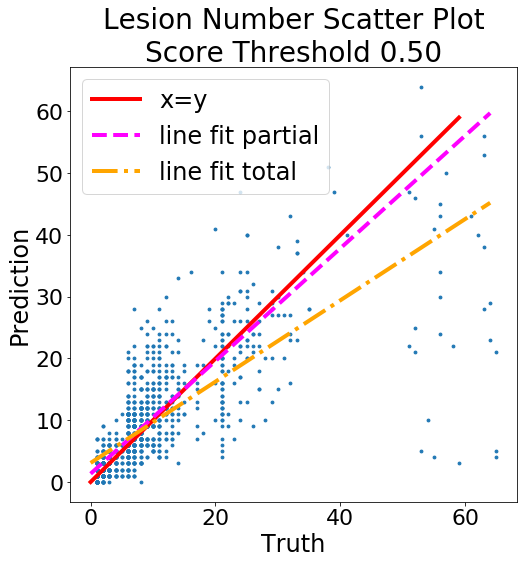

In [101]:
plot_fit(50,save_name="./scatter_plot_yolov4_50.pdf")

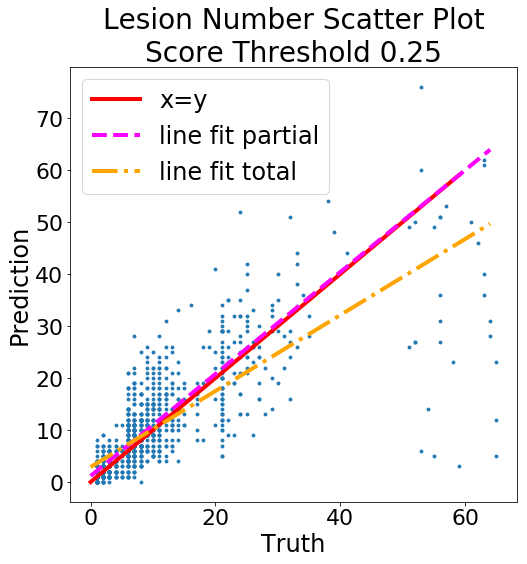

In [99]:
plot_fit(25)

In [102]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            save_name = "normalized_cm_{}.pdf".format(int(time.time()))
        else:
            title = 'Confusion matrix'
            save_name = "not_normalized_cm_{}.pdf".format(int(time.time()))
            
    if normalize:
        save_name = "normalized_cm_{}.pdf".format(int(time.time()))
    else:
        save_name = "not_normalized_cm_{}.pdf".format(int(time.time()))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     print((unique_labels(y_true.astype(int), y_pred.astype(int))).dtype)
#     classes = classes[unique_labels(y_true.astype(int), y_pred.astype(int))]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
#            title=title,
#            ylabel='True label',
#            xlabel='Predicted label',
        )
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("True severity",fontsize=14)
    ax.set_ylabel("Predicted severity",fontsize=14)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", 
                    fontsize=18)
    fig.tight_layout()
    plt.savefig(save_name, bbox_inches='tight', transparent=True)
    
    return ax

Confusion matrix, without normalization


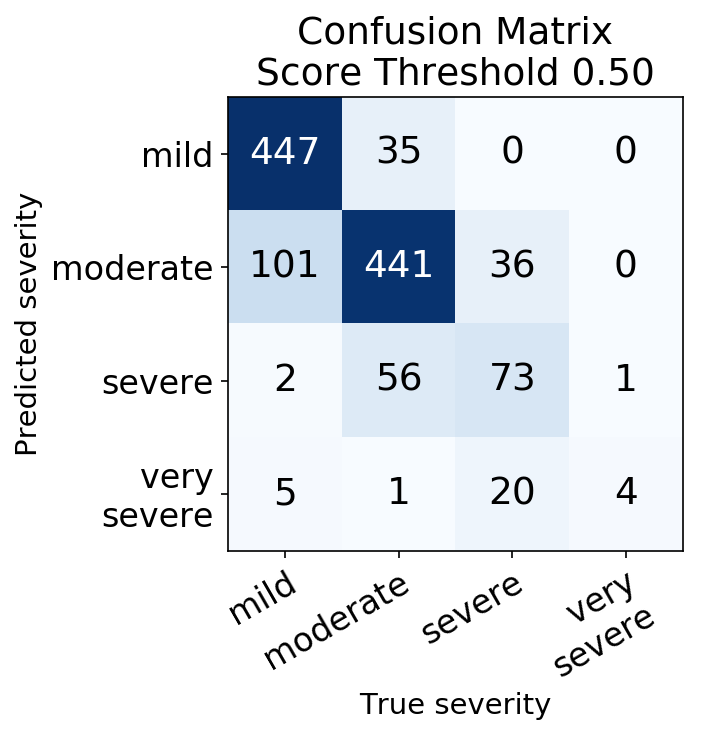

In [103]:
thre = 50

plot_confusion_matrix(df_ann["severity_level"].values, df_ann[f"res{thre}_level"].values, classes=["mild", "moderate", "severe", "very\nsevere"], title=f"Confusion Matrix\nScore Threshold 0.{thre}")

Confusion matrix, without normalization


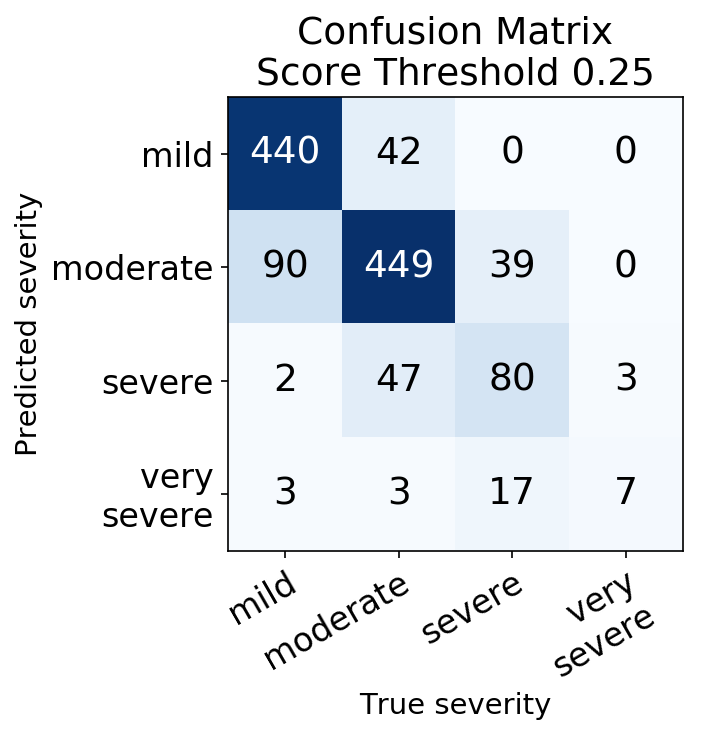

In [89]:
thre = 25

plot_confusion_matrix(df_ann["severity_level"].values, df_ann[f"res{thre}_level"].values, classes=["mild", "moderate", "severe", "very\nsevere"], title=f"Confusion Matrix\nScore Threshold 0.{thre}")